In this notebook, we will implement a simple RNN unit from scratch, using only Numpy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

We're going to use a simple toy data set here, were we predict the next number in a sequence, here generated by the sinusoidal function. We're also going to add in a bit of jitter to make the example a bit more interesting.

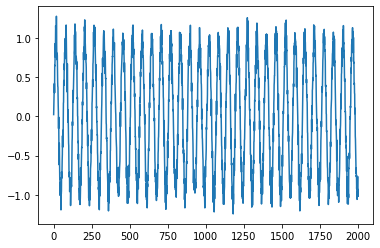

In [ ]:
X = np.sin(np.arange(0, 200, 0.1)) + np.random.randn(2000) / 10
plt.plot(X)

To make the training loop later a bit easier to code up, we're going to cut up this sequence into multiple subsequences, with the next number as the associated target. We hence create a bunch of different instance, each of which is a sequence of varying length which will be presented to the network from left-to-right. We're also going to split off a piece of the sequence to use as our validation set.

In [ ]:
X_train, X_valid = [], []
y_train, y_valid = [], []

for i in range(1, len(X)//2):
  X_train.append(X[:i])
  y_train.append(X[i])

for i in range(len(X)//2, len(X)):
  X_valid.append(X[:i])
  y_valid.append(X[i])

In [ ]:
print("First three sequences:", X_train[:3])
print("First three targets:", y_train[:3])

First three sequences: [array([0.02309365]), array([0.02309365, 0.16449495]), array([0.02309365, 0.16449495, 0.21950805])]
First three targets: [0.16449494757540623, 0.2195080508309076, 0.33283307468453194]


Next, we define our RNN unit weights. The equations for a simple RNN unit are as follows:

- $h_t = tanh(W_{xh}x_t+W_{hh}h_{t-1}+b_h)$ for the hidden output, with two weight matrices, one for the input, and one for the last hidden state, which are then summed together together with bias weights to create a hidden state vector $h_t$ for each time step. A hyperbolic tangent is used as the activation function, but a sigmoid function can also be used.
- For the output in each time step, we have a separate weight matrix, which works over the hidden state vector: $y_t=W_{hy}h_t + b_y$.

We also a trivial initialization scheme here to initialize the weights and biases. Note that RNNs are quite sensitive to vanishing/exploding gradients, but the simple initialization used here works well for what we're trying to show here.

In [ ]:
hidden_size = 32
output_size = 1
input_size = 1

Whh = np.random.randn(hidden_size, hidden_size) / 1000
Wxh = np.random.randn(hidden_size, input_size)  / 1000
Why = np.random.randn(output_size, hidden_size) / 1000

bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

Our function to perform a forward pass through the RNN unit is relatively simple. We just step through the given sequence and keep track of the hidden state output after each time step as we will need it later, as well as the output of the RNN unit after the final time step (note that you could keep track and return the output after each time step as well, this is helpful in case you want to stack multiple RNN layers on top of each other, for instance):

In [ ]:
def forward(sequence):
  h = np.zeros((Whh.shape[0], 1))
  hidden_states = [h]

  for i, x in enumerate(sequence):
    x = x.reshape(-1, 1)
    h = np.tanh(Wxh @ x + Whh @ h + bh)
    hidden_states.append(h)

  y = Why @ h + by
  
  return y[0][0], hidden_states

We also define a helper function to predict and get the average loss over a given data set:

In [ ]:
loss = lambda t, p: (t-p)**2

def get_preds_and_loss(X, y):
  outputs = []
  avg_loss = 0
  for sequence, true in zip(X, y):
    output, hidden_states = forward(sequence)
    outputs.append(output)
    avg_loss += loss(true, output)
  avg_loss /= len(X)
  return outputs, avg_loss

Loss for untrained network: 0.508816699051115 on train, 0.5098520531702583 on validation


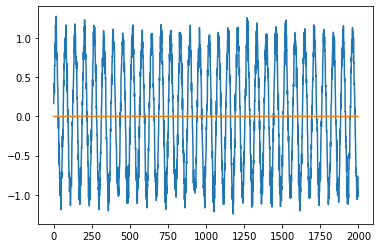

In [ ]:
outputs_train, loss_train = get_preds_and_loss(X_train, y_train)
outputs_valid, loss_valid = get_preds_and_loss(X_valid, y_valid)
print("Loss for untrained network:", loss_train, 'on train,', loss_valid, 'on validation')

# Plot the predictions
plt.plot(X[1:])
plt.plot(outputs_train + outputs_valid)

We can now implement the backpropagation routine.

We need the gradients of $W_{hh}$, $W_{xh}$ and $b_h$. Using the chain rule, we can write e.g.:

$\frac{\partial L}{\partial W_{xh}} = \frac{\partial L}{\partial y}\sum_t \frac{\partial y}{\partial h_t} \times \frac{\partial h_t}{\partial W_{xh}}$. The sum is necessary as changing $W_{xh}$ affects $h_t$ in every time step, which all ultimately affect the output and hence the loss. So in order to calculate the gradient, we need to backpropagate through all time steps (from right the left this time around), hence: backpropagation through time.

$\frac{\partial h_t}{\partial W_{xh}}$ is calculated as follows, $h_t = tanh(W_{xh}x_t+W_{hh}h_{t-1}+b_h)$. Since $\frac{\partial tanh(x)}{\partial x} = 1 - tanh^2(x)$, we get:

- $\frac{\partial h_t}{\partial W_{xh}} = (1-h_t^2)x_t$
- $\frac{\partial h_t}{\partial W_{hh}} = (1-h_t^2)h_{t-1}$
- $\frac{\partial h_t}{\partial b_{h}} = (1-h_t^2)$

We also need $\frac{\partial y}{\partial h_t}$, which we can calculate recursively:

- $\frac{\partial y}{\partial h_t} = \frac{\partial y}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_t} = \frac{\partial y}{\partial h_{t+1}} (t-h^2_t)W_{hh}$

Since we start from the last hidden state and work from right to left, we know $\frac{\partial y}{\partial h_{t+1}}$ when we want to calculate $\frac{\partial h_{t+1}}{\partial h_t}$. Except for the last hidden state, which as no next state, so:

- $\frac{\partial y}{\partial h_n} = W_{hy}$ (as $y_t=W_{hy}h_t + b_y$ and the final $y = y_t$ for the last step)

We can now implement all these steps:

In [ ]:
def backpropagate(sequence, d_L_d_y, learn_rate=2e-2):
  global Whh, Wxh, Why, bh, by

  _, hidden_states = forward(sequence)

  d_Why = d_L_d_y @ hidden_states[-1].T
  d_by  = d_L_d_y

  d_bh  = np.zeros(bh.shape)
  d_Whh = np.zeros(Whh.shape)
  d_Wxh = np.zeros(Wxh.shape)
  d_h   = Why.T @ d_L_d_y

  # Backpropagate through time
  n = len(sequence)
  for t in reversed(range(n)):
    d_tanh = (1 - hidden_states[t + 1] ** 2) * d_h
    d_bh  += d_tanh
    d_Whh += d_tanh @ hidden_states[t].T
    d_Wxh += d_tanh @ sequence[t].reshape(-1, 1).T
    d_h    = Whh @ d_tanh

  # Prevent exploding gradients
  for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
    np.clip(d, -5, 5, out=d)

  # Update weights and biases using gradient descent
  Whh -= learn_rate * d_Whh
  Wxh -= learn_rate * d_Wxh
  Why -= learn_rate * d_Why
  bh  -= learn_rate * d_bh
  by  -= learn_rate * d_by

We can now train our RNN unit. The only thing we still need is $\frac{\partial L}{\partial y}$, but as we use the square error loss, this is easy, e.g. simply $2\hat{y} - 2y$ or $\hat{y} - y$ as we can remove the constant.

In [ ]:
for epoch in range(2):
  for sequence, true in zip(X_train, y_train):
    output, hidden_states = forward(sequence)
    backpropagate(sequence, np.array(output - true).reshape(-1, 1))
  _, avg_loss = get_preds_and_loss(X_train, y_train)
  print(epoch, avg_loss)

0 0.030199140922258057
1 0.027673771154320063


Finally, we take a look at the predictions on the train and test set:

Loss for untrained network: 0.027673771154320063 on train, 0.029089708332803426 on validation


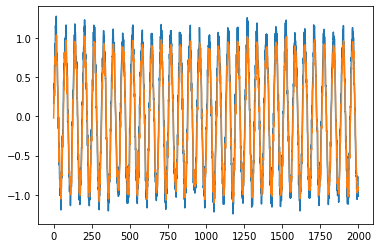

In [ ]:
outputs_train, loss_train = get_preds_and_loss(X_train, y_train)
outputs_valid, loss_valid = get_preds_and_loss(X_valid, y_valid)
print("Loss for untrained network:", loss_train, 'on train,', loss_valid, 'on validation')

# Plot the predictions
plt.plot(X[1:])
plt.plot(outputs_train + outputs_valid)

This looks already pretty nice, though keep in mind that we've taken some shortcuts here:

- We're only predicting a very simple function.
- RNNs easily suffer from either vanishing our exploding gradients. We've prevented this here by gradient clipping and a weight initialization using a normal distribution, but for real-life cases, better approaches are required.
- We train on sequences with varying length, but do not put a limit in terms of how long a sequence can get. This causes that sequences later in the training set are quite long, leading to the network still overfitting somewhat.
- Typically, instead of using SGD, you'd again apply gradient descent using minibatches. This will typically require (e.g. in Keras) that all sequences in the same batch do have the same length (to make the tensor mathematics work out).